<a href="https://colab.research.google.com/github/jefferyxm/llm-hongyi.li-colab/blob/main/GenAI_ML_HW10_Speech_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section 0: Preparing**

## Activate GPU
Since you will fine-tune a model, you **MUST** activate GPU so that this homework can be done in reasonable time (1~2 hrs)

### **MUST READ**:

Colab does **NOT** guarantee the GPU access for free user ([ref](https://research.google.com/colaboratory/faq.html#idle-timeouts)). It is possible you get an message saying "Cannot connect to GPU backend" which means there are no enough GPU resources for you now. When this happens, you may need to **wait for one (or more) day or login different Google account to do the homework**.

### Enable GPU

1. Click on "Runtime" (or "執行階段") in the header.
2. Click on "Change runtime type" (or "變更執行階段類型") in the drop menu.
3. Select "T4 GPU" and save. (You can select "A100 GPU" or "V100 GPU" if you have Colab Pro)
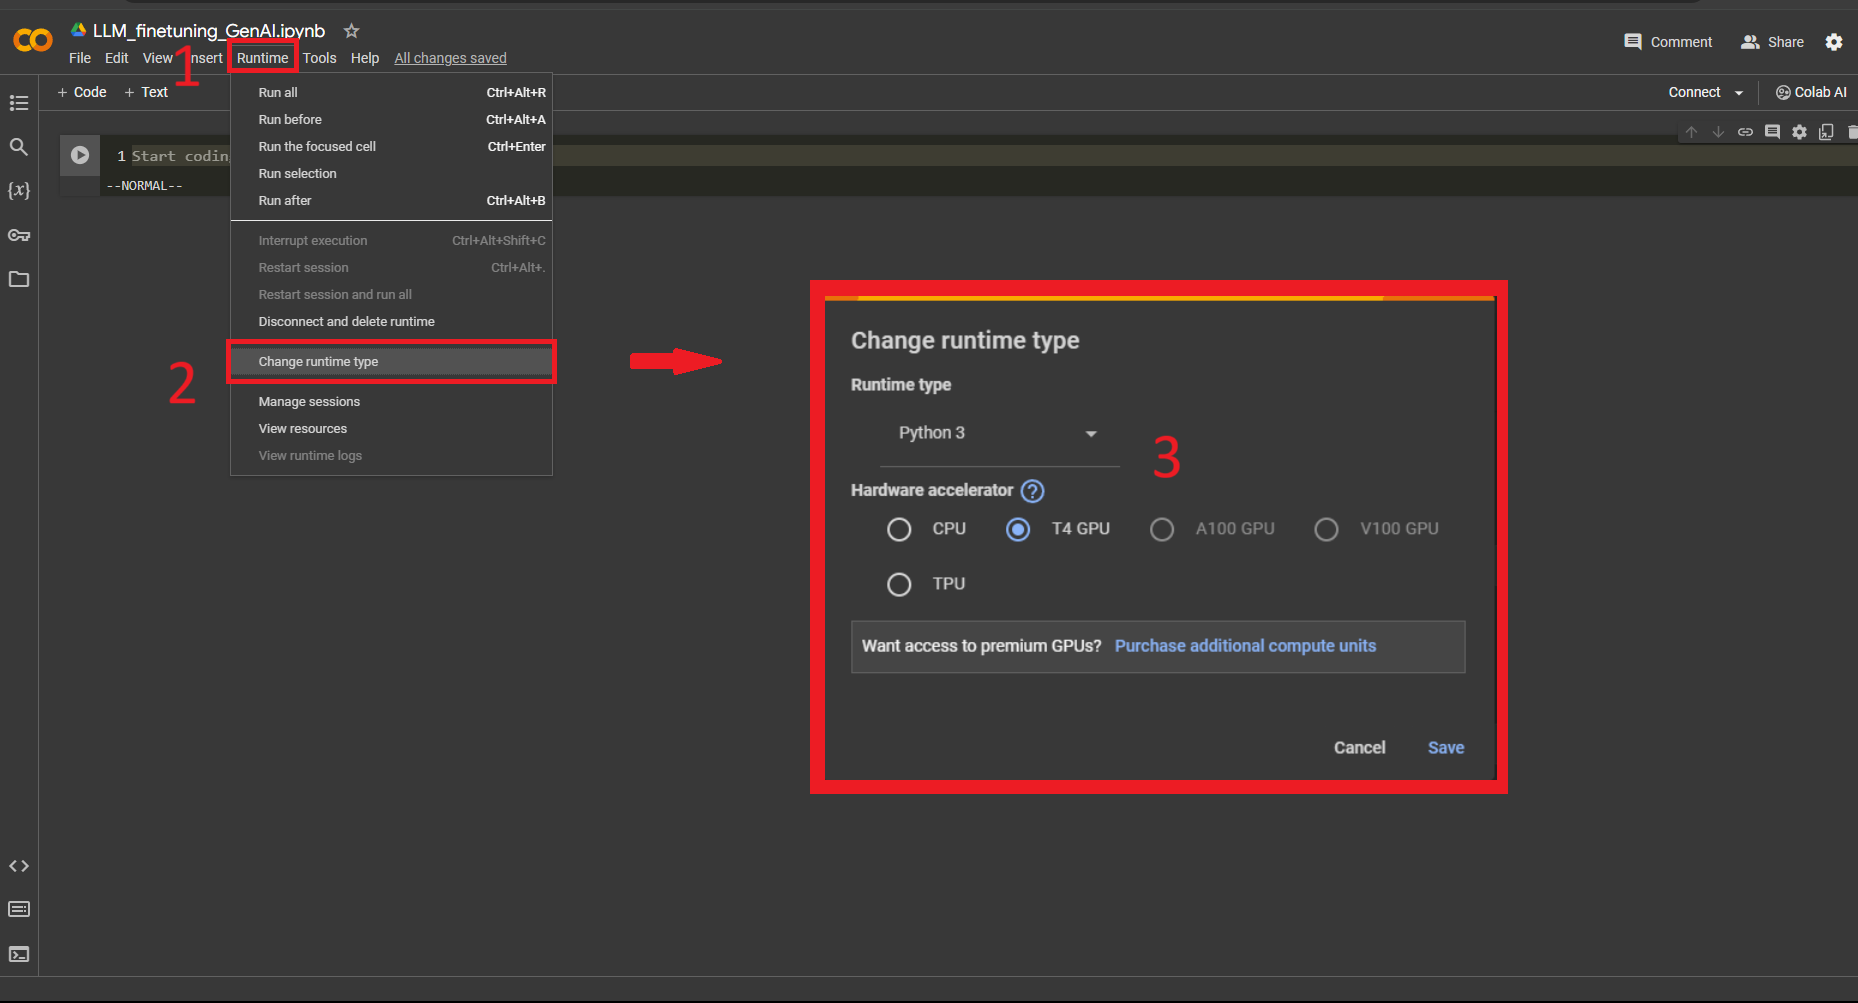

## Check the status of your GPU

In [ ]:
!nvidia-smi

## Preparing Data & Packages


In [ ]:
!pip install -U gdown
!gdown --folder --id 133NtWF1nJUzQ0AuWOLvOWDl4X1dmXkjz
!gdown --id 1Y7dNUO8nSp8kXsqoQEHUWJyPzVe_5vSW
!unzip -q /content/emotion_audio.zip -d /content/emotion_audio
!pip install transformers==4.55.3
!pip install torchcodec

# **Section 1: Tokenizer (How the model interprets audio)**
Understanding how audio is encoded into tokens.
In this section, the model we used is mimi.

### Load Mimi Model / 載入 Mimi 模型

In [ ]:
import torch
import torchaudio
from transformers import MimiModel, AutoFeatureExtractor
from IPython.display import Audio

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained Mimi model and move it to the selected device
mimi_model = MimiModel.from_pretrained("kyutai/mimi").to(device)
feature_extractor = AutoFeatureExtractor.from_pretrained("kyutai/mimi")
target_sr = feature_extractor.sampling_rate

### Define a function to extract Mimi's token / 建立函數用以取出 Mimi 的 token

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# ======================================================
# This is the central function of the assignment.
# It extracts Mimi’s tokens from an input audio file,
# and will be repeatedly used in later tasks.
# ======================================================
def get_mimi_token(audio_path: str, num_quantizers: int = 32) -> torch.Tensor:# Set num_quantizers to default (default 32)
    """
    Extract Mimi audio tokens from a given audio file.

    Args:
        audio_path (str): Path to the audio file (.wav).
        num_quantizers (int): Number of quantizers to use in the encoder.

    Returns:
        torch.Tensor: Encoded audio tokens of shape (1, num_RVQ_layers, frames) on the active device.
    """
    # Load audio
    waveform, sr = torchaudio.load(audio_path)

    # Convert stereo to mono if needed
    if waveform.shape[0] == 2:
        waveform = waveform.mean(dim=0, keepdim=True)

    # Resample if needed
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)
        waveform = resampler(waveform)

    # Convert to numpy and extract features
    audio_sample = waveform.squeeze().numpy()
    inputs = feature_extractor(
        raw_audio=audio_sample,
        sampling_rate=target_sr,
        return_tensors="pt"
    )

    # Move input tensor to the same device as the model
    input_values = inputs["input_values"].to(device)

    # --- Core Logic ---
    with torch.no_grad():
        encoder_outputs = mimi_model.encode(input_values, num_quantizers=num_quantizers)

    return encoder_outputs.audio_codes  # shape: (1, num_RVQ_layers, frames)```

In [ ]:
######################## (Q1 ~ Q4) ########################
# Encode:
audio_tokens_2s = get_mimi_token("/content/audiofiles/2sAudio.wav")
audio_tokens_4s = get_mimi_token("/content/audiofiles/4sAudio.wav")

# -- Q1, Q2, Q3 --
# Print shapes of the two audio token tensors
print("=== Audio Token Shapes ===\n")

print("▶ 2-second Audio")
print(f"Shape: {audio_tokens_2s.shape}")
display(Audio("/content/audiofiles/2sAudio.wav"))

print("\n▶ 4-second Audio")
print(f"Shape: {audio_tokens_4s.shape}")
display(Audio("/content/audiofiles/4sAudio.wav"))


# -- Q4 --
# Print a small portion of the tensor (first codebook, first 10 frames)
print("\n=== Sample from audio tokens (partial) ===")
print(audio_tokens_2s.cpu()[0, 0, :10])

# Print the data type of a single value
print("\n=== Data Type of a Single Value ===")
print(type(audio_tokens_2s[0][0][0].item()))
###########################################################

### Now, define a function to get the embedding from the code.
### / 接著，建立一個取出Mimi's token 對應之 embedding 的函數

In [ ]:
# Get all the Mimi's Token layers.
semantic_layers = mimi_model.quantizer.semantic_residual_vector_quantizer.layers
acoustic_layers = mimi_model.quantizer.acoustic_residual_vector_quantizer.layers

def get_embedding_from_token(
    token_index: int,
    codebook_layer: int,
) -> torch.Tensor:
    # First, select the correct codebook based on the layer index.
    if codebook_layer == 0:
        codebook = semantic_layers[0].codebook
    else:
        # Get the correct acoustic codebook (remember to subtract 1 for the index).
        codebook = acoustic_layers[codebook_layer - 1].codebook
    with torch.no_grad():
        # Look up the single token in the codebook to get the vector.
        # 'codebook.embed' holds the table of all possible vectors.
        vector = codebook.embed[token_index]

    return vector

In [ ]:
######################## (Q5) ########################
tokens = get_mimi_token("/content/audiofiles/4sAudio.wav")
embedding = get_embedding_from_token(token_index = 2047 ,codebook_layer = 0).cpu()

print("=== Embedding Shape ===")
print(embedding.shape)
print("=== Embedding content ===")
print(embedding)
######################################################

### Define functions that converting Mimi tokens into embeddings, and visualizing with UMAP.
### / 建立用來從音檔取出 embedding 與 透過 UMAP 視覺化結果的函數

In [ ]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import umap
import numpy as np
# --- Specify all the wanted layers to compare and analyze here ---
LAYERS_TO_COMPARE = [0, 6, 16, 31]
# Get all the Mimi's token layers.
semantic_layers = mimi_model.quantizer.semantic_residual_vector_quantizer.layers
acoustic_layers = mimi_model.quantizer.acoustic_residual_vector_quantizer.layers

# Extract token embeddings for a single RVQ layers
def get_embedding_from_audio(audio_tokens: torch.Tensor, codebook_layer: int) -> torch.Tensor:
    if not 0 <= codebook_layer < (1 + len(acoustic_layers)):
        raise ValueError(f"Invalid `codebook_layer`: {codebook_layer}")

    # Check if we need the first (semantic) layer.
    if codebook_layer == 0:
        codebook = semantic_layers[0].codebook
    # Otherwise, get one of the acoustic layers.
    else:
        codebook = acoustic_layers[codebook_layer - 1].codebook

    with torch.no_grad():
        # Select the tokens for the specific layer we want.
        tokens_for_this_layer = audio_tokens[:, codebook_layer]

        # Look up the tokens in the codebook to get the actual vectors.
        # 'codebook.embed' holds the table of all possible vectors.
        vectors = codebook.embed[tokens_for_this_layer]

    return vectors

# UMAP plotting function
def plot_umap_comparison(vectors_by_layer, labels, layers_to_plot):
    """
    Plot side-by-side UMAP comparison for multiple layers.
    """
    num_layers = len(layers_to_plot)
    fig, axes = plt.subplots(1, num_layers, figsize=(8 * num_layers, 7))
    if num_layers == 1:
        axes = [axes]

    print("\n--- Starting Visualization with UMAP ---")

    emotion_colors = {
        "Amused": "orange", "Angry": "red", "Disgusted": "green",
        "Sleepy": "purple", "Neutral": "grey"
    }
    point_colors = [emotion_colors.get(label, "black") for label in labels]

    for i, layer_idx in enumerate(layers_to_plot):
        ax = axes[i]
        vectors = vectors_by_layer[layer_idx]
        title = f"Utterance-Level UMAP (Layer {layer_idx})"

        if not vectors:
            ax.text(0.5, 0.5, 'No data for this layer.', ha='center', va='center')
            ax.set_title(title)
            continue

        X = np.array(vectors)
        print(f"Running UMAP for Layer {layer_idx} on {X.shape[0]} vectors...")

        # n_neighbors: controls the balance between local and global structure.
        # Smaller values focus more on local details.
        # min_dist: controls how tightly points are packed together.
        # Smaller values make points more clustered.
        reducer = umap.UMAP(
            n_neighbors=15,
            min_dist=0.1,
            n_components=2,
            random_state=42
        )
        embeddings_2d = reducer.fit_transform(X)

        ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=point_colors, s=20, alpha=0.8)
        ax.set_title(title, fontsize=16)
        ax.set_xlabel("UMAP Dimension 1")
        ax.set_ylabel("UMAP Dimension 2")
        ax.grid(True)

    patches = [mpatches.Patch(color=color, label=emotion) for emotion, color in emotion_colors.items() if emotion in set(labels)]
    fig.legend(handles=patches, title="Emotion", loc='upper right', bbox_to_anchor=(0.98, 0.95))

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

### Process emotion-labeled audio files by extracting Mimi’s tokens at layers [0, 6, 16, 31].
### / 批量處裡有情緒標記的音檔，取出各自在 [0, 6, 16, 31] 層的 Mimi's tokens
### **(This step may take approximately 2–5 minutes.)**

In [ ]:
# Processing all Emotion data
# this may take two minutes

utterance_vectors_by_layer = {layer: [] for layer in LAYERS_TO_COMPARE}
emotion_labels_for_vectors = []
# Define dataset path and emotions of interest
dataset_path = "/content/emotion_audio"
emotions_to_analyze = ["Amused", "Angry", "Disgusted", "Neutral", "Sleepy"]

# Collect all audio files
all_files = []
for emotion in emotions_to_analyze:
    folder = os.path.join(dataset_path, f"jenie_{emotion}")
    if not os.path.isdir(folder):
        continue
    for fname in os.listdir(folder):
        if fname.endswith((".wav", ".flac")):
            all_files.append((emotion, os.path.join(folder, fname)))

print(f"Found {len(all_files)} audio files across {len(emotions_to_analyze)} folders.\n")

# Process with tqdm.
with tqdm(total=len(all_files), desc="Processing files", unit="file") as pbar:
    for emotion, audio_path in all_files:
        audio_filename = os.path.basename(audio_path)

        # Show current file name in the progress bar (updates in place)
        pbar.set_postfix_str(f"{emotion} - {audio_filename}")

        try:
            # Extract Mimi tokens
            tokens = get_mimi_token(audio_path)

            # Generate mean embeddings for each layer
            for layer_idx in LAYERS_TO_COMPARE:
                embedding = get_embedding_from_audio(tokens, codebook_layer=layer_idx)
                utterance_vector = embedding.squeeze(0).mean(dim=0)
                utterance_vectors_by_layer[layer_idx].append(utterance_vector.cpu().numpy())

            # Store emotion label
            emotion_labels_for_vectors.append(emotion)

        except Exception as e:
            pbar.set_postfix_str(f"Skipped {audio_filename} (error)")

        pbar.update(1)

print("\nFinished processing all utterances.")
from IPython.display import Audio, display
import os, tempfile
import soundfile as sf

print("\n" + "=" * 72)
print("Try listening to audio files with different emotions.（試聽看看不同情緒樣本音檔）")
print("=" * 72)

tmp_dir = os.path.join(tempfile.gettempdir(), "emotion_pcm16")
os.makedirs(tmp_dir, exist_ok=True)

for emotion in emotions_to_analyze:
    folder = os.path.join(dataset_path, f"jenie_{emotion}")
    if not os.path.isdir(folder):
        print(f"[{emotion:<9}] Folder not found: {folder}")
        continue

    files = [f for f in os.listdir(folder) if f.endswith((".wav", ".flac"))]
    if not files:
        print(f"[{emotion:<9}] No audio files found.")
        continue

    sample_path = os.path.join(folder, sorted(files)[0])

    x, sr = sf.read(sample_path)
    out_path = os.path.join(tmp_dir, f"{emotion}_{os.path.basename(sample_path)}")
    sf.write(out_path, x, sr, subtype="PCM_16")

    print(f"[{emotion:<9}] {os.path.basename(sample_path)}")
    display(Audio(filename=out_path))

In [ ]:
######################## (Q6) ########################
# Plot UMAP of emotion-labeled audios and analyze results for the given questions.
plot_umap_comparison(
    utterance_vectors_by_layer,
    emotion_labels_for_vectors,
    LAYERS_TO_COMPARE
)
######################################################

 # **Section 2: Detokenizer (How the model generates speech)**
 Decoding tokens back into audio.
 In this section, we use the decoder to get token back to the wavform.

### We use the same model (Mimi) and function, which was loaded in Section 1.
### / 使用已經在 Section 1 被載入的相同模型（Mimi）

In [ ]:
# Check if Mimi model and get_mimi_token function are properly loaded
try:
    # Verify Mimi model is loaded
    assert "mimi_model" in globals(), "Mimi model not found"
    assert mimi_model is not None, "Mimi model is None"

    # Verify get_mimi_token function is loaded
    assert "get_mimi_token" in globals(), "get_mimi_token function not found"
    assert callable(get_mimi_token), "get_mimi_token is not callable"

    print("✅ All good: Mimi model and get_mimi_token are properly initialized.")

except AssertionError as e:
    if "mimi_model" in str(e):
        print("⚠️ Warning: Mimi model is missing. Please go back to Section 1, first block, and download the model again.")
    elif "get_mimi_token" in str(e):
        print("⚠️ Warning: get_mimi_token function is missing. Please return to Section 1 and ensure the function is defined.")
    else:
        print(f"⚠️ Warning: {e}")

### Install requirement
### / 載入接下來題目所需要用到的相關工具函式庫

In [ ]:
# This package (PESQ) provides an objective measure of speech reconstruction quality.
!pip install pesq
# This package (Whisper) provides an ASR function to transcribe speech into text.
!pip install openai-whisper

### Define a function to display both original and decoded audios.
### / 建立用來播放原始與解碼後音檔的函數

In [ ]:
import os
from pesq import pesq

def display_original_decoded_audios(audio_path: str, idx=None, total=None):
    """
    Play the original audio file and its re-decoded version using mimi_model.
    Also compute PESQ score between original and decoded.
    """
    name = os.path.basename(audio_path)
    header = f"=== [{idx}/{total}] {name} ===" if idx and total else f"=== {name} ==="
    print(header)

    if not os.path.exists(audio_path):
        print(f"⚠️ File not found: {audio_path}")
        return

    # Play original audio
    print("▶ Original")
    display(Audio(audio_path))

    # Decode with Mimi
    tokens = get_mimi_token(audio_path, num_quantizers=8)
    decoded = mimi_model.decode(tokens)[0].squeeze(0).detach().cpu().numpy()

    print("▶ Decoded")
    display(Audio(decoded, rate=feature_extractor.sampling_rate))

    # Load and preprocess original audio
    waveform, sr = torchaudio.load(audio_path)
    if waveform.shape[0] == 2:  # stereo to mono
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != target_sr:  # resample if needed
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)(waveform)

    # Convert both signals to 16k for PESQ
    ref = torchaudio.transforms.Resample(orig_freq=24000, new_freq=16000)(waveform).squeeze().numpy()
    deg = torchaudio.transforms.Resample(orig_freq=24000, new_freq=16000)(torch.from_numpy(decoded)).squeeze().numpy()

    # PESQ score
    score = pesq(16000, ref, deg, 'wb')
    print(f"📊 PESQ (Perceptual Evaluation of Speech Quality) Score: {score:.4f}")

In [ ]:
######################## (Q7 ~ Q8) ########################
# Observe the reconstruction results of these audio files and answer Q7–Q8.
files = [
    "//content/audiofiles/English_speech.wav",
    "//content/audiofiles/Chinese_speech.wav",
    "//content/audiofiles/laughter.wav",
    "//content/audiofiles/music.wav",
]

for i, f in enumerate(files, 1):
    display_original_decoded_audios(f, idx=i, total=len(files))
##############################################################

### Reconstruct the speech from this layer-wised shuffled audio token file.
### / 從被打亂的音訊 token 檔案嘗試解碼出原始音檔

In [ ]:
# Load the audio puzzle
audio_tokens_shuffled = torch.load("//content/audiofiles/audio_tokens_shuffled.pt").cuda()

def decode_audio_with_guess(ans):
    """Reorder shuffled audio tokens according to guessed index and play the decoded audio."""
    if not isinstance(ans, (list, tuple)):
        raise ValueError("your_ans must be a list or tuple")
    if len(ans) != 4:
        raise ValueError("your_ans must have exactly 4 elements")
    if sorted(ans) != [0, 1, 2, 3]:
        raise ValueError("your_ans must be a permutation of [0,1,2,3] with no duplicates")

    color_map = {
        0: "\033[38;5;160m",  # dark red
        1: "\033[38;5;172m",  # muted orange
        2: "\033[38;5;70m",   # soft green
        3: "\033[38;5;25m"    # deep blue
    }
    reset = "\033[0m"

    print("Your guess:")
    print(" ".join(f"{color_map[a]}|{reset}" for a in ans))
    print(" ".join(f"{color_map[a]}{a}{reset}" for a in ans))
    print(" ".join(f"{color_map[a]}|{reset}" for a in ans))

    ans_tensor = torch.tensor(ans, device=audio_tokens_shuffled.device)
    audio_tokens = audio_tokens_shuffled.index_select(1, ans_tensor)
    audio_values = mimi_model.decode(audio_tokens)[0]
    display(Audio(audio_values.squeeze(0).detach().cpu().numpy(),
                  rate=feature_extractor.sampling_rate))


In [ ]:
######################## TODO (Q9) ########################
# Task: Recover the original order of the four RVQ layers (indices 0–3) in `audio_tokens_shuffled.pt`.
# Context: The file contains Mimi-encoded 4-layer tokens whose inter-layer order (dim=1) was randomly permuted.
# Instructions:
#   1) Explore different layer permutations (no repeats; 4! = 24 total).
#   2) Decode each candidate order with Mimi and listen to the audio.
#   3) Select the permutation that restores intelligible speech and, based on the recovered content, answer Q9.
# Note: You can brute-force all 24 permutations—decode and listen one by one—to pinpoint the original audio.


your_ans = [0, 1, 2, 3] # you can modify here (e.g., [0, 2, 3, 1])
decode_audio_with_guess(your_ans)
############################################################

### Define the functions required for the following task.
### / 建立底下題目中所需要的函數

In [ ]:
def merge_mimi_units(
    tensor1: torch.Tensor,
    tensor2: torch.Tensor,
    split_index: int = 5
) -> torch.Tensor:
    """
    Merges two Mimi unit tensors by combining RVQ layers from each based on a split index.

    Args:
        tensor1 (torch.Tensor): The source tensor for the first set of RVQ layers.
                                Expected shape: (1, 8, T1).
        tensor2 (torch.Tensor): The source tensor for the remaining RVQ layers.
                                Expected shape: (1, 8, T2).
        split_index (int, optional): The index at which to switch from tensor1 to tensor2.
                                     Takes the first `split_index` RVQ layers from tensor1.
                                     Defaults to 5. Must be between 0 and 8.

    Returns:
        torch.Tensor: The merged tensor, with shape (1, 8, T) where T is the
                      aligned frame length.
    """
    # --- Input Validation ---
    num_RVQ_layers = 8
    assert tensor1.shape[0] == 1 and tensor1.shape[1] == num_RVQ_layers, \
        f"tensor1 must have shape (1, {num_RVQ_layers}, T1)"
    assert tensor2.shape[0] == 1 and tensor2.shape[1] == num_RVQ_layers, \
        f"tensor2 must have shape (1, {num_RVQ_layers}, T2)"
    assert 0 <= split_index <= num_RVQ_layers, \
        f"split_index must be an integer between 0 and {num_RVQ_layers} (inclusive)."

    # --- Frame Length Alignment ---
    # Aligns tensors to the length of the longer one to preserve information.
    T1 = tensor1.shape[2]
    T2 = tensor2.shape[2]
    target_length = max(T1, T2)

    def align_tensor(tensor, length):
        current_length = tensor.shape[2]
        if current_length == length:
            return tensor
        # Pad with the last frame if shorter
        padding = tensor[:, :, -1:].repeat(1, 1, length - current_length)
        return torch.cat([tensor, padding], dim=2)

    tensor1_aligned = align_tensor(tensor1, target_length)
    tensor2_aligned = align_tensor(tensor2, target_length)

    # Take the first `split_index` RVQ layers from tensor1 and the rest from tensor2.
    merged = torch.cat([
        tensor1_aligned[:, :split_index, :],
        tensor2_aligned[:, split_index:, :]
    ], dim=1)

    audio_values = mimi_model.decode(merged)[0]

    return audio_values


import whisper
import numpy as np
import tempfile
import soundfile as sf

model = whisper.load_model("base")

def asr_from_numpy(wav_np: np.ndarray, sr: int = 24000) -> str:
    # Resample to 16kHz
    wav_16k = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(wav_np).squeeze().numpy()

    # Save as temporary wav file for Whisper
    with tempfile.NamedTemporaryFile(suffix=".wav") as f:
        sf.write(f.name, wav_16k, 16000)
        result = model.transcribe(f.name, temperature=0.0, fp16=False)
    return result["text"]


### Listen to the two original audio clips / 聆聽 Q10 的兩個原始音檔

In [ ]:
import math
# ANSI colors
RED = "\x1b[91m"
BLUE = "\x1b[34m"
RESET = "\x1b[0m"

# This function is only for visualization / making the output look nicer.
def show_two_color(i: int, *, total: int):
    print("—" * 120)
    bar = f"{RED}{'|'* i}{BLUE}{'|' * (total - i)}{RESET}"
    print(f"\r RVQ layers: {bar}  split_index={i}/{total}", end="", flush=True)

print(f"🔈 Displaying first speech (Alice.wav). RVQ layers: {RED}{'|'*8}{RESET} From left to right: layers 0–7.")
display(Audio("/content/audiofiles/Alice.wav", rate=24000))

print(f"🔈 Displaying second speech (James.wav). RVQ layers: {BLUE}{'|'*8}{RESET} From left to right: layers 0–7.")
display(Audio("/content/audiofiles/James.wav", rate=24000))

print(f"📘 Note: The red bars {RED}{'|'}{RESET} represent the token layers occupied by the first audio (Alice),\n while the blue bars {BLUE}{'|'}{RESET} represent the token layers occupied by the second audio (James).")

In [ ]:
######################## (Q10) ########################
# Run all code, observe the mixed-audio results and transcriptions,
# then answer Question Q10.

num_quantizers = 8 # Specify 8-layer tokens
# Extract Mimi tokens from two audio files
audio_tokens1 = get_mimi_token("/content/audiofiles/Alice.wav", num_quantizers = num_quantizers) ## You can complete this assignment "without" modifying the code. / 在這個作業中你可以「不用」修改程式碼就能夠回答題目。
audio_tokens2 = get_mimi_token("/content/audiofiles/James.wav", num_quantizers = num_quantizers) ## However, if you want to explore the relationships between variables, you may swap the two audio files and experiment with different scenarios. / 但你也可以為了研究變項間關係，交換這兩者音檔，嘗試實驗看看不同情境。

# Mix tokens layer by layer and show results
for i in range(num_quantizers + 1):
  show_two_color(i, total = num_quantizers)  # Display split status, making the output look nicer.
  audio_values = merge_mimi_units(audio_tokens1, audio_tokens2, split_index = i)  # Merge audio
  display(Audio(audio_values.squeeze(0).detach().cpu().numpy(), rate=feature_extractor.sampling_rate))  # Play audio
  ASR = asr_from_numpy(audio_values.squeeze(0).detach().cpu(), sr=24000)  # Run ASR
  print(f'📝 Transcribed text:\n "{ASR}"')  # Print transcription
########################################################

# **Section 3: The Model's Brain (How the model generates entirely new audio)**
How language models process and predict token sequences.

## Huggingface login & Load CSM Model / 登入 Huggingface & 載入 CSM Model

### You need the huggingface token (hf_token) to login to huggingface and install the csm-1b model.

### Login to access the CSM model here: https://huggingface.co/sesame/csm-1b
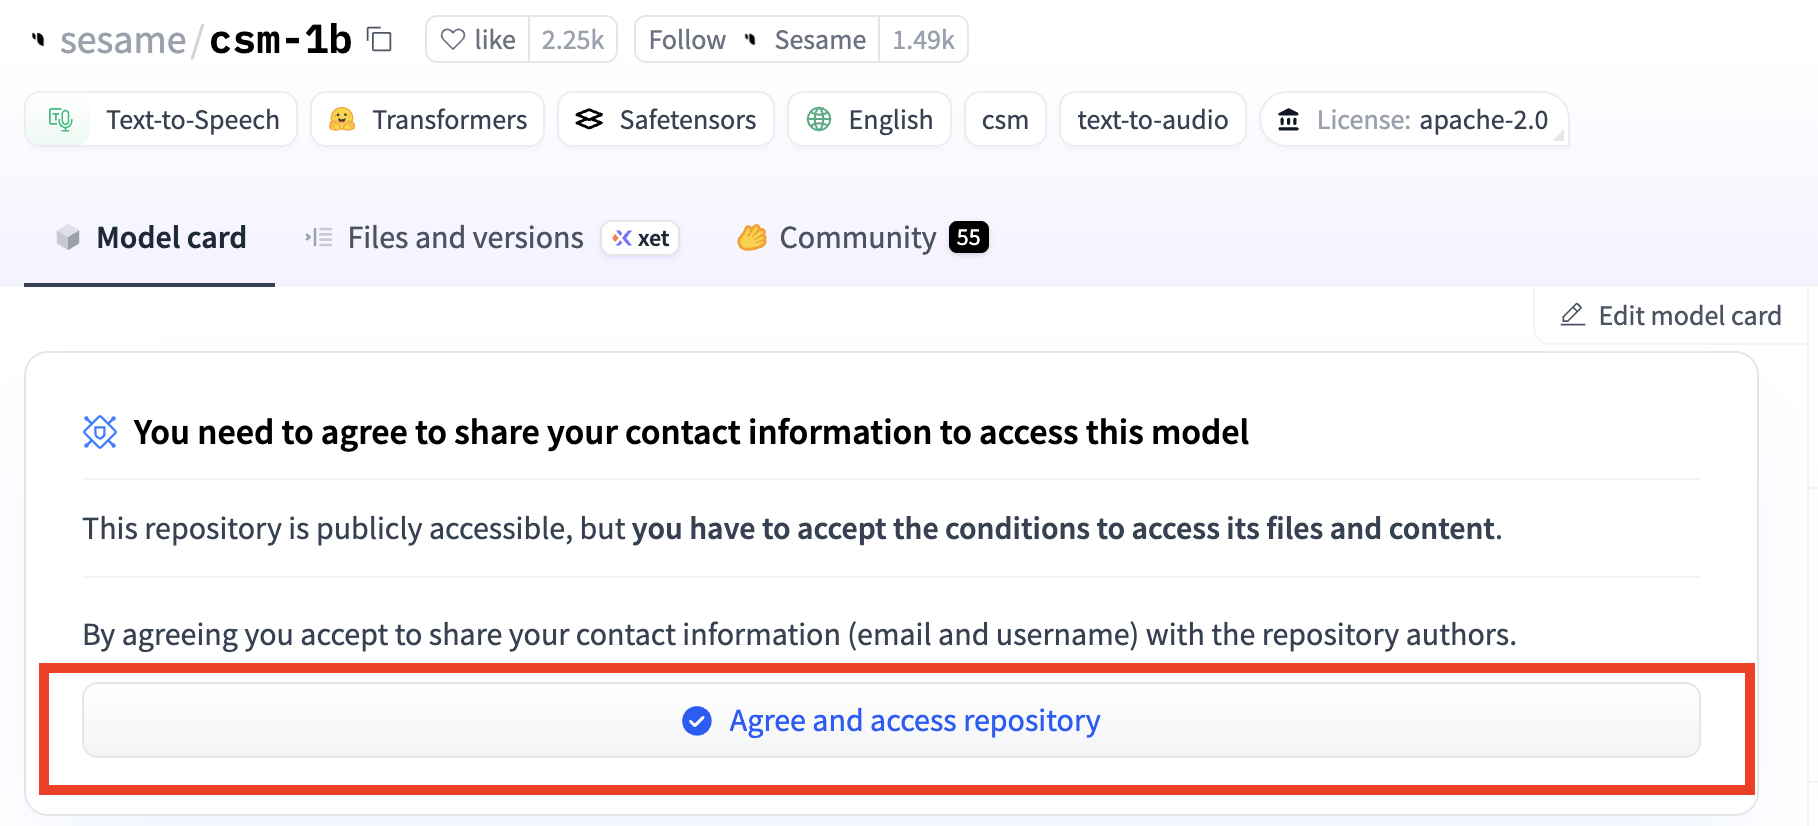
### / 你需要有 huggingface token 來登入 huggingface 與下載 csm-1b model。
### / 模型在 huggingface 的網址為：https://huggingface.co/sesame/csm-1b

### Load CSM Model（This could take some time) / 載入 CSM 模型（執行約需3分鐘）

In [ ]:
import torch
from transformers import CsmForConditionalGeneration, AutoProcessor
from huggingface_hub import login
import torchaudio
from IPython.display import Audio

login("Your access token") # insert access token here


model_id = "sesame/csm-1b"
device = "cuda" if torch.cuda.is_available() else "cpu"

# load the model and the processor
processor = AutoProcessor.from_pretrained(model_id)
Csm_model = CsmForConditionalGeneration.from_pretrained(model_id, device_map=device)

# Define function convert audio path into numpy
def path_to_numpy(prompt_audio_path):
  waveform, sample_rate = torchaudio.load(prompt_audio_path)  # waveform shape: [channels, samples]

  # Convert to mono if stereo
  if waveform.shape[0] > 1:
      waveform = waveform.mean(dim=0, keepdim=True)

  # Convert to numpy array and remove channel dimension
  return(waveform[0].numpy())

In [ ]:
emily_voice_path = "/content/audiofiles/Emily.wav"
jason_voice_path = "/content/audiofiles/Jason.wav"

emily_audio = path_to_numpy(emily_voice_path)
jason_audio = path_to_numpy(jason_voice_path)

print("▶ Playing input audio (Emily)...")
display(Audio(emily_voice_path))

print("▶ Playing input audio (Jason)...")
display(Audio(jason_voice_path))

######################## TODO (Q11) ########################
# Try different input sequences, experiment with text and audio combinations,
# then answer Question Q11.
input_sequence = [
    #Audio prompt:
    {
        "role": "0",
        "content": [
            {"type": "text", "text": "With this instant ramen and duct tape, my Doomsday Pigeon will finally take flight."},
            {"type": "audio", "path": emily_audio},
        ],
    },
    {
        "role": "1",
        "content": [
            {"type": "text", "text": "That'll be $238. Midnight customers always pile up junk food like this. Guess it's cheaper than therapy."},
            {"type": "audio", "path": jason_audio},
        ],
    },
    ####### You can modify the following part to complete the assignment.#######
    #Text prompt:
    {
        "role": "1", # You should follow the prompt on the slide.
        "content": [{"type": "text", "text": "You can test with any sentence here"}],
    },
]

############################################################

########################## (Q12) ###########################

# Tokenize and prepare model input
#/ 處理輸入的資訊成模型可接受之輸入
inputs = processor.apply_chat_template(
    input_sequence,
    tokenize=True,
    return_dict=True,
).to("cuda")

# Using Csm generate function to generate output with given processed input
#/ 傳入處理好的輸入，到 CSM 模型的生成函數裡。
audio_token = Csm_model.generate(**inputs, output_audio=False)
audio_token_T = audio_token.transpose(1, 2)


# Using Mimi to decode CSM result back to audio
#/ 透過 Section 1 載入的 Mimi 模型，來解析 CSM 的輸出成音訊
audio_values = mimi_model.decode(audio_token_T)[0]

print("\n \n ▶ Playing the predicted audio...")
display(Audio(audio_values.squeeze(0).detach().cpu().numpy(), rate=feature_extractor.sampling_rate))
############################################################